In [ ]:
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from glob import glob
import cv2
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt


torch.manual_seed(42)
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device Name:", torch.cuda.get_device_name(0))

def create_blend_mask(patch_size, blend_width=64):
    mask = np.ones((patch_size, patch_size), dtype=np.float32)
    for i in range(blend_width):
        weight = i / blend_width
        mask[i, :] *= weight
        mask[-(i+1), :] *= weight
        mask[:, i] *= weight
        mask[:, -(i+1)] *= weight
    return mask

def predict_with_smooth_blending(model, image, patch_size=512, overlap=64, device='cuda'):
    model.eval()
    H, W = image.shape
    stride = patch_size - overlap
    num_patches_h = (H - overlap) // stride + (1 if (H - overlap) % stride > 0 else 0)
    num_patches_w = (W - overlap) // stride + (1 if (W - overlap) % stride > 0 else 0)
    prediction = np.zeros((H, W), dtype=np.float32)
    weight_map = np.zeros((H, W), dtype=np.float32)
    blend_mask = create_blend_mask(patch_size, overlap//2)
    with torch.no_grad():
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                start_h = i * stride
                start_w = j * stride
                end_h = min(start_h + patch_size, H)
                end_w = min(start_w + patch_size, W)
                patch = image[start_h:end_h, start_w:end_w]
                pad_h = patch_size - patch.shape[0]
                pad_w = patch_size - patch.shape[1]
                if pad_h > 0 or pad_w > 0:
                    patch = np.pad(patch, ((0, pad_h), (0, pad_w)), mode='reflect')
                patch_norm = patch.astype(np.float32)
                mean_val = patch_norm.mean()
                std_val = patch_norm.std()
                if std_val > 1e-6:
                    patch_norm = (patch_norm - mean_val) / std_val
                patch_tensor = torch.tensor(patch_norm).unsqueeze(0).unsqueeze(0).to(device)
                logits = model(patch_tensor)
                prob = torch.sigmoid(logits).cpu().numpy()[0, 0]
                if pad_h > 0 or pad_w > 0:
                    prob = prob[:patch_size-pad_h, :patch_size-pad_w]
                current_blend = blend_mask[:prob.shape[0], :prob.shape[1]]
                prediction[start_h:end_h, start_w:end_w] += prob * current_blend
                weight_map[start_h:end_h, start_w:end_w] += current_blend
    weight_map[weight_map == 0] = 1
    prediction = prediction / weight_map
    return prediction

class PerImageZScore(A.ImageOnlyTransform):
    def __init__(self, p=1.0):
        super().__init__(p=p)
    def apply(self, img, **params):
        img = img.astype(np.float32)
        m = img.mean()
        s = img.std()
        if s < 1e-6:
            s = 1e-6
        return (img - m) / s

class EnhancedPatchDataset(Dataset):
    def __init__(self, image_paths, mask_paths, patch_size=512, overlap=64, transform=None, training=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.patch_size = patch_size
        self.overlap = overlap
        self.transform = transform
        self.training = training
        self.patches = []
        self.create_patches()
    def create_patches(self):
        stride = self.patch_size - self.overlap if self.training else self.patch_size
        for ipath, mpath in zip(self.image_paths, self.mask_paths):
            img = cv2.imread(ipath, cv2.IMREAD_GRAYSCALE).astype(np.float32)
            mask = cv2.imread(mpath, cv2.IMREAD_GRAYSCALE)
            mask = (mask > 127).astype(np.float32)
            H, W = img.shape
            for i in range(0, H - self.patch_size + 1, stride):
                for j in range(0, W - self.patch_size + 1, stride):
                    img_patch = img[i:i+self.patch_size, j:j+self.patch_size]
                    mask_patch = mask[i:i+self.patch_size, j:j+self.patch_size]
                    if self.training and mask_patch.sum() < 100:
                        if np.random.random() > 0.1:
                            continue
                    self.patches.append((img_patch, mask_patch))
            if H % stride != 0 or W % stride != 0:
                remaining_patches = []
                if H % stride != 0:
                    for j in range(0, W - self.patch_size + 1, stride):
                        i = H - self.patch_size
                        img_patch = img[i:i+self.patch_size, j:j+self.patch_size]
                        mask_patch = mask[i:i+self.patch_size, j:j+self.patch_size]
                        remaining_patches.append((img_patch, mask_patch))
                if W % stride != 0:
                    for i in range(0, H - self.patch_size + 1, stride):
                        j = W - self.patch_size
                        img_patch = img[i:i+self.patch_size, j:j+self.patch_size]
                        mask_patch = mask[i:i+self.patch_size, j:j+self.patch_size]
                        remaining_patches.append((img_patch, mask_patch))
                if H % stride != 0 and W % stride != 0:
                    i, j = H - self.patch_size, W - self.patch_size
                    img_patch = img[i:i+self.patch_size, j:j+self.patch_size]
                    mask_patch = mask[i:i+self.patch_size, j:j+self.patch_size]
                    remaining_patches.append((img_patch, mask_patch))
                self.patches.extend(remaining_patches)
    def __len__(self):
        return len(self.patches)
    def __getitem__(self, idx):
        img, mask = self.patches[idx]
        img = np.expand_dims(img, axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask).float()
        if mask.ndim == 2:
            mask = mask.unsqueeze(0)
        elif mask.ndim == 3 and mask.shape[0] != 1:
            mask = mask.permute(2, 0, 1)

        return img.float(), mask.float()




class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=3, stride=1, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class ConvBlockDec(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=3, stride=1):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(out_channels*2, out_channels, kernel, stride, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x, skip_connection):
        x = self.upconv(x)
        if x.shape[-2:] != skip_connection.shape[-2:]:
            sh, sw = skip_connection.shape[-2:]
            xh, xw = x.shape[-2:]
            dh, dw = (sh - xh)//2, (sw - xw)//2
            skip_connection = skip_connection[..., dh:dh+xh, dw:dw+xw]
        x = torch.cat((x, skip_connection), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class Unet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.enc1 = ConvBlock(in_channels, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        self.maxpool = nn.MaxPool2d(2)
        self.base = ConvBlock(512, 1024)
        self.dec4 = ConvBlockDec(1024, 512)
        self.dec3 = ConvBlockDec(512, 256)
        self.dec2 = ConvBlockDec(256, 128)
        self.dec1 = ConvBlockDec(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, 1)
    def forward(self, x):
        s1 = self.enc1(x)
        s2 = self.enc2(self.maxpool(s1))
        s3 = self.enc3(self.maxpool(s2))
        s4 = self.enc4(self.maxpool(s3))
        x = self.base(self.maxpool(s4))
        x = self.dec4(x, s4)
        x = self.dec3(x, s3)
        x = self.dec2(x, s2)
        x = self.dec1(x, s1)
        x = self.final_conv(x)
        return x





CUDA Available: True
CUDA Device Name: Tesla T4


In [ ]:





model = Unet().to(device)

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=20, p=0.5),
    #A.ElasticTransform(alpha=40, sigma=10, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=0.3),
    PerImageZScore(),
    ToTensorV2()
])

test_transform = A.Compose([
    PerImageZScore(),
    ToTensorV2()
])

all_images = sorted(glob("/content/drive/MyDrive/data/images/*.jpg"))
all_masks = sorted(glob("/content/drive/MyDrive/data/labels/*.jpg"))
train_size = int(0.8*len(all_images))
train_images, test_images = all_images[:train_size], all_images[train_size:]
train_masks, test_masks = all_masks[:train_size], all_masks[train_size:]

train_dataset = EnhancedPatchDataset(
    train_images, train_masks,
    patch_size=512, overlap=64,
    transform=train_transform,
    training=True
)

test_dataset = EnhancedPatchDataset(
    test_images, test_masks,
    patch_size=512, overlap=0,
    transform=test_transform,
    training=False
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True)


Epoch [1/30]


Training:   0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipython-input-1183740567.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.4104 | Val Loss: 0.5048 | Pixel Acc: 82.49% | Pixel Err: 17.51% | Dice: 0.8965 | IoU: 0.8125
Best model saved! Dice: 0.8965

Epoch [2/30]


Train Loss: 0.3091 | Val Loss: 0.4949 | Pixel Acc: 75.60% | Pixel Err: 24.40% | Dice: 0.8234 | IoU: 0.6998

Epoch [3/30]


Train Loss: 0.2731 | Val Loss: 0.3189 | Pixel Acc: 88.65% | Pixel Err: 11.35% | Dice: 0.9270 | IoU: 0.8640
Best model saved! Dice: 0.9270

Epoch [4/30]


Train Loss: 0.2559 | Val Loss: 0.2561 | Pixel Acc: 91.56% | Pixel Err: 8.44% | Dice: 0.9477 | IoU: 0.9006
Best model saved! Dice: 0.9477

Epoch [5/30]


Train Loss: 0.2430 | Val Loss: 0.2356 | Pixel Acc: 92.01% | Pixel Err: 7.99% | Dice: 0.9504 | IoU: 0.9055
Best model saved! Dice: 0.9504
Testing on image: /content/drive/MyDrive/data/images/train-volume24.jpg
Image shape: (512, 512)


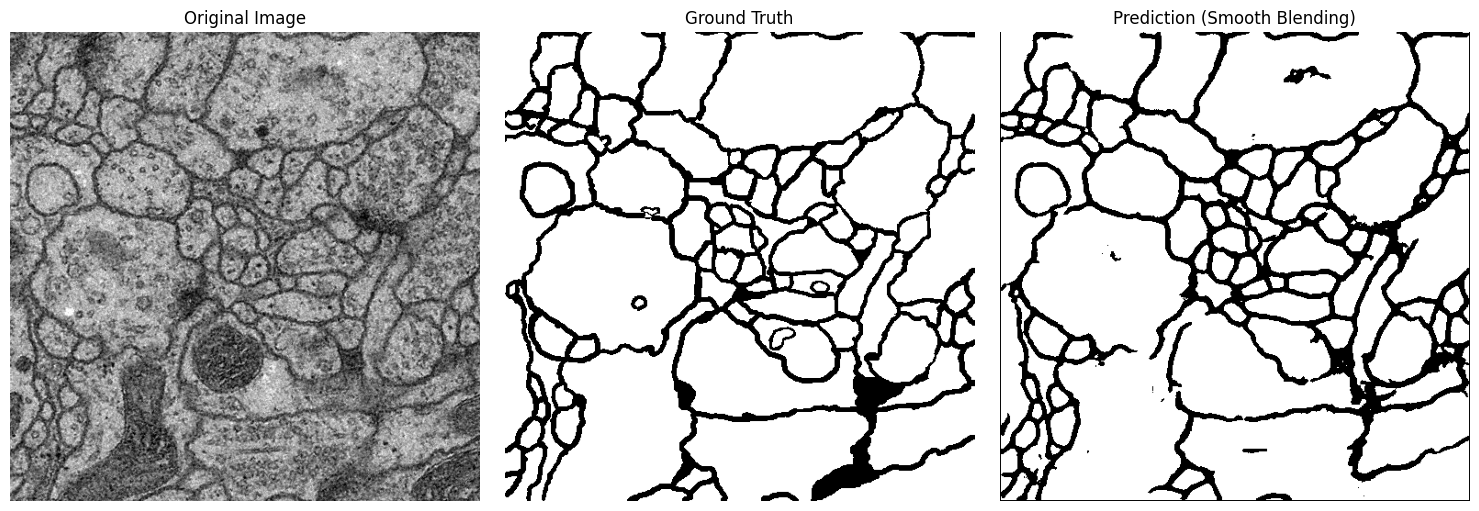

Full Image Metrics - Dice: 0.9487, IoU: 0.9023

Epoch [6/30]


Train Loss: 0.2398 | Val Loss: 0.2333 | Pixel Acc: 91.66% | Pixel Err: 8.34% | Dice: 0.9486 | IoU: 0.9022

Epoch [7/30]


Train Loss: 0.2316 | Val Loss: 0.2290 | Pixel Acc: 91.78% | Pixel Err: 8.22% | Dice: 0.9490 | IoU: 0.9031

Epoch [8/30]


Train Loss: 0.2241 | Val Loss: 0.2264 | Pixel Acc: 92.37% | Pixel Err: 7.63% | Dice: 0.9527 | IoU: 0.9097
Best model saved! Dice: 0.9527

Epoch [9/30]


Train Loss: 0.2224 | Val Loss: 0.2269 | Pixel Acc: 91.98% | Pixel Err: 8.02% | Dice: 0.9501 | IoU: 0.9049

Epoch [10/30]


Train Loss: 0.2175 | Val Loss: 0.2200 | Pixel Acc: 92.17% | Pixel Err: 7.83% | Dice: 0.9516 | IoU: 0.9077
Testing on image: /content/drive/MyDrive/data/images/train-volume24.jpg
Image shape: (512, 512)


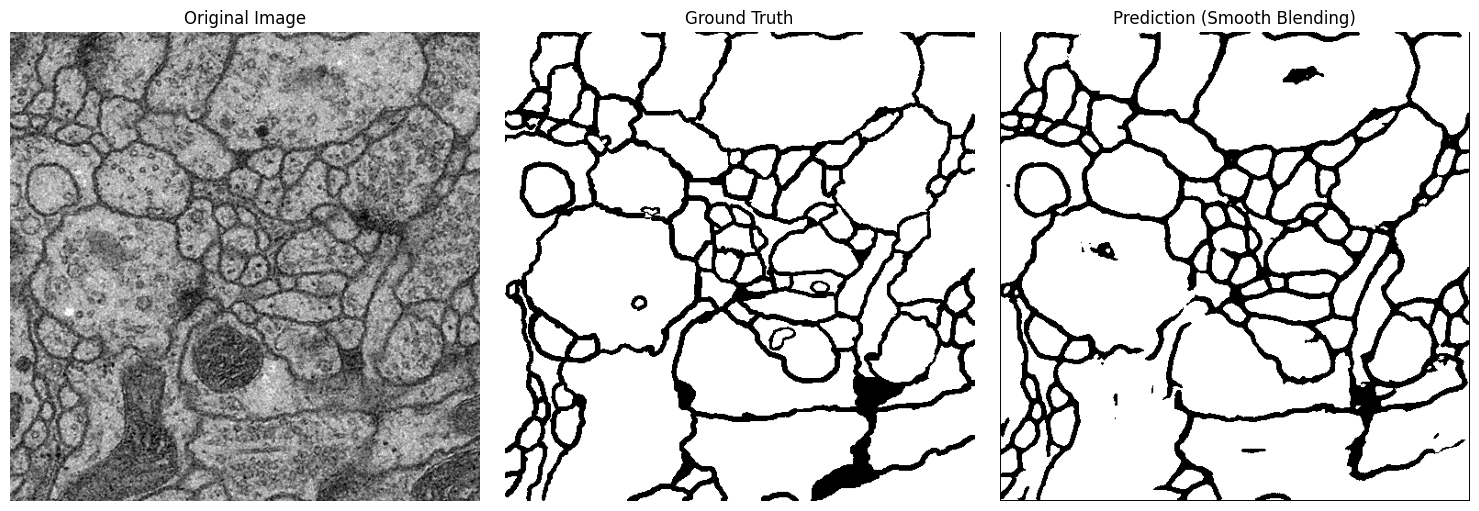

Full Image Metrics - Dice: 0.9515, IoU: 0.9075

Epoch [11/30]


Train Loss: 0.2139 | Val Loss: 0.2213 | Pixel Acc: 92.21% | Pixel Err: 7.79% | Dice: 0.9514 | IoU: 0.9073

Epoch [12/30]


Train Loss: 0.2104 | Val Loss: 0.2223 | Pixel Acc: 92.32% | Pixel Err: 7.68% | Dice: 0.9517 | IoU: 0.9080

Epoch [13/30]


Train Loss: 0.2050 | Val Loss: 0.2068 | Pixel Acc: 92.01% | Pixel Err: 7.99% | Dice: 0.9507 | IoU: 0.9061

Epoch [14/30]


Train Loss: 0.2011 | Val Loss: 0.2040 | Pixel Acc: 92.52% | Pixel Err: 7.48% | Dice: 0.9539 | IoU: 0.9119
Best model saved! Dice: 0.9539

Epoch [15/30]


Train Loss: 0.1981 | Val Loss: 0.2234 | Pixel Acc: 91.61% | Pixel Err: 8.39% | Dice: 0.9474 | IoU: 0.9002
Testing on image: /content/drive/MyDrive/data/images/train-volume24.jpg
Image shape: (512, 512)


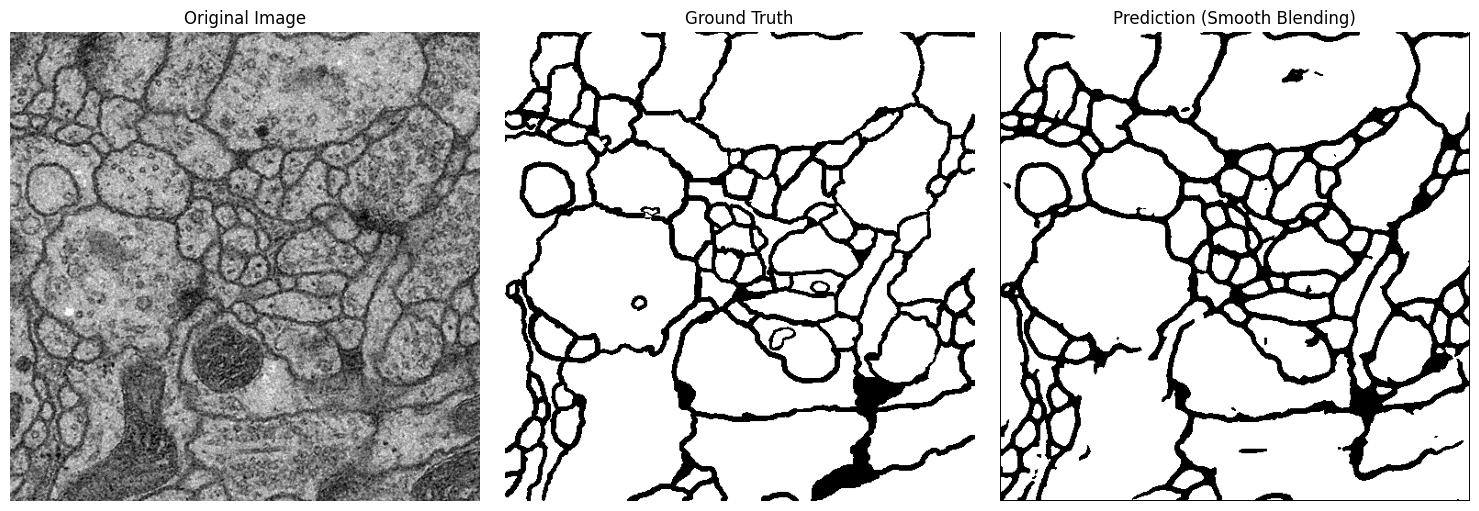

Full Image Metrics - Dice: 0.9483, IoU: 0.9017

Epoch [16/30]


Train Loss: 0.1948 | Val Loss: 0.2030 | Pixel Acc: 92.14% | Pixel Err: 7.86% | Dice: 0.9512 | IoU: 0.9070

Epoch [17/30]


Train Loss: 0.1956 | Val Loss: 0.2001 | Pixel Acc: 92.30% | Pixel Err: 7.70% | Dice: 0.9523 | IoU: 0.9089

Epoch [18/30]


Train Loss: 0.1909 | Val Loss: 0.1928 | Pixel Acc: 92.14% | Pixel Err: 7.86% | Dice: 0.9517 | IoU: 0.9078

Epoch [19/30]


Train Loss: 0.1860 | Val Loss: 0.1901 | Pixel Acc: 92.62% | Pixel Err: 7.38% | Dice: 0.9542 | IoU: 0.9125
Best model saved! Dice: 0.9542

Epoch [20/30]


Train Loss: 0.1865 | Val Loss: 0.1924 | Pixel Acc: 92.30% | Pixel Err: 7.70% | Dice: 0.9522 | IoU: 0.9088
Testing on image: /content/drive/MyDrive/data/images/train-volume24.jpg
Image shape: (512, 512)


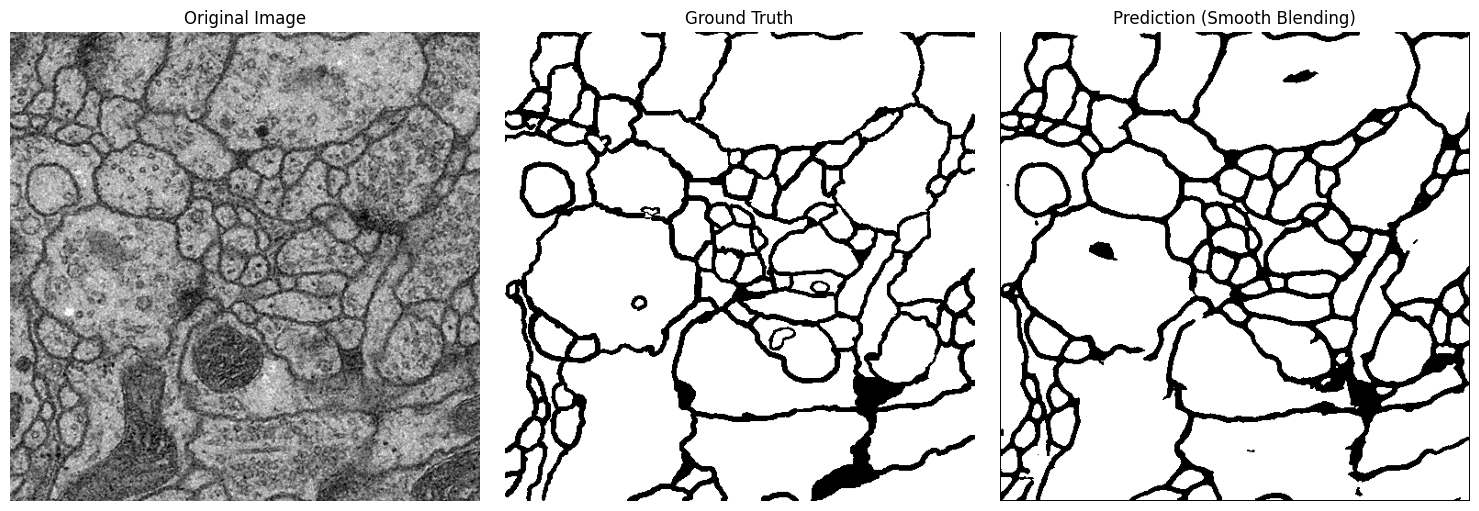

Full Image Metrics - Dice: 0.9508, IoU: 0.9061

Epoch [21/30]


Train Loss: 0.1814 | Val Loss: 0.1869 | Pixel Acc: 92.31% | Pixel Err: 7.69% | Dice: 0.9526 | IoU: 0.9095

Epoch [22/30]


Train Loss: 0.1793 | Val Loss: 0.1820 | Pixel Acc: 92.53% | Pixel Err: 7.47% | Dice: 0.9540 | IoU: 0.9120

Epoch [23/30]


Train Loss: 0.1805 | Val Loss: 0.1956 | Pixel Acc: 91.91% | Pixel Err: 8.09% | Dice: 0.9499 | IoU: 0.9045

Epoch [24/30]


Train Loss: 0.1751 | Val Loss: 0.1822 | Pixel Acc: 92.02% | Pixel Err: 7.98% | Dice: 0.9513 | IoU: 0.9071

Epoch [25/30]


Train Loss: 0.1738 | Val Loss: 0.1855 | Pixel Acc: 92.35% | Pixel Err: 7.65% | Dice: 0.9525 | IoU: 0.9093
Testing on image: /content/drive/MyDrive/data/images/train-volume24.jpg
Image shape: (512, 512)


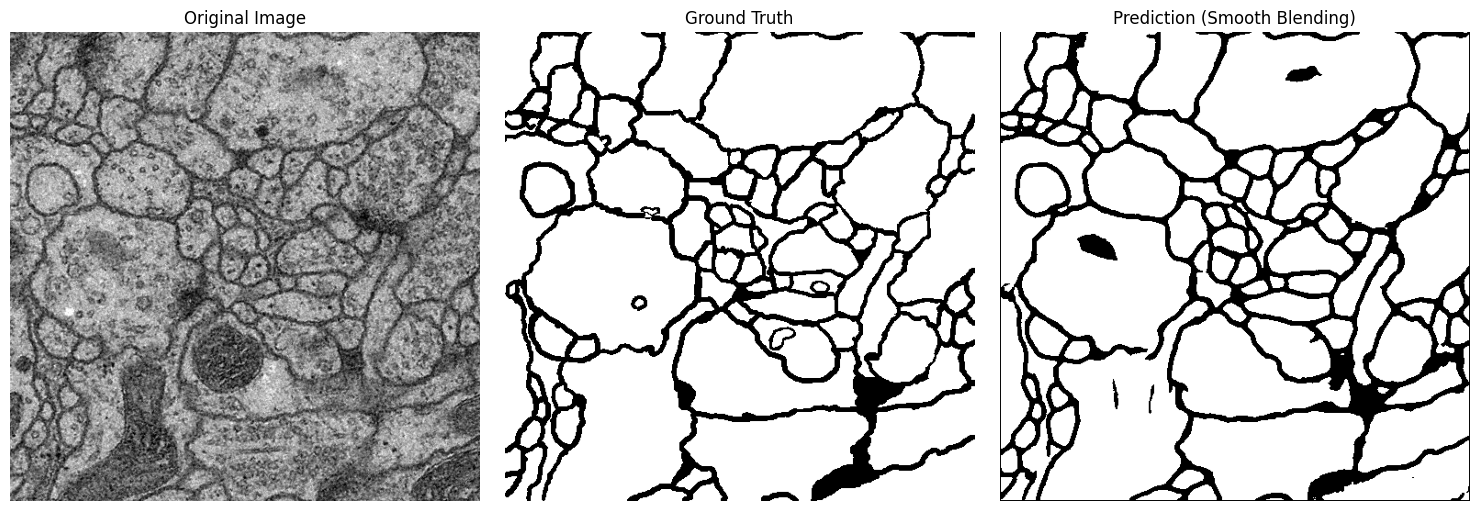

Full Image Metrics - Dice: 0.9526, IoU: 0.9095

Epoch [26/30]


Train Loss: 0.1704 | Val Loss: 0.1800 | Pixel Acc: 92.47% | Pixel Err: 7.53% | Dice: 0.9532 | IoU: 0.9105

Epoch [27/30]


Train Loss: 0.1690 | Val Loss: 0.1810 | Pixel Acc: 91.98% | Pixel Err: 8.02% | Dice: 0.9505 | IoU: 0.9056

Epoch [28/30]


Train Loss: 0.1678 | Val Loss: 0.1723 | Pixel Acc: 92.73% | Pixel Err: 7.27% | Dice: 0.9550 | IoU: 0.9139
Best model saved! Dice: 0.9550

Epoch [29/30]


Train Loss: 0.1649 | Val Loss: 0.1695 | Pixel Acc: 92.69% | Pixel Err: 7.31% | Dice: 0.9549 | IoU: 0.9137

Epoch [30/30]


Train Loss: 0.1626 | Val Loss: 0.1731 | Pixel Acc: 92.76% | Pixel Err: 7.24% | Dice: 0.9549 | IoU: 0.9137
Testing on image: /content/drive/MyDrive/data/images/train-volume24.jpg
Image shape: (512, 512)


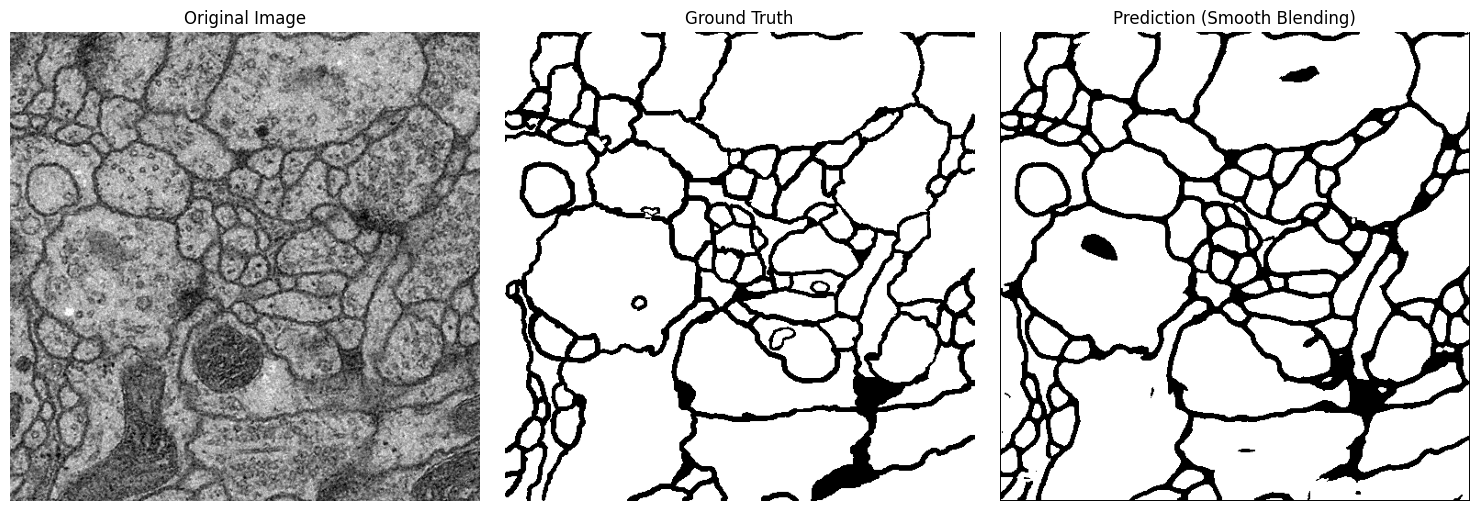

Full Image Metrics - Dice: 0.9526, IoU: 0.9094


In [ ]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

class EnhancedLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, logits, target):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(logits, target)
        dice = dice_loss(logits, target)
        return 0.6 * bce_loss + 0.4 * dice


optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = EnhancedLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=4
)
scaler = torch.amp.GradScaler("cuda")

def train_fn(loader, model, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0
    loop = tqdm(loader, desc="Training", leave=False)
    for imgs, masks in loop:
        imgs, masks = imgs.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(imgs)
            loss = loss_fn(logits, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    return total_loss / max(1, len(loader))

@torch.no_grad()
def eval_fn(loader, model, loss_fn, device):
    model.eval()
    total_loss = 0.0
    dice_list, iou_list, pixel_correct, total_pixels = [], [], 0, 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        logits = model(imgs)
        total_loss += loss_fn(logits, masks).item()
        preds = torch.sigmoid(logits)
        preds_bin = (preds > 0.45).float()

        pixel_correct += (preds_bin == masks).sum().item()
        total_pixels += masks.numel()
        inter = (preds_bin * masks).sum(dim=(1,2,3))
        union = preds_bin.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3)) - inter
        dice = (2*inter + 1e-7)/(preds_bin.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3)) + 1e-7)
        iou  = (inter + 1e-7)/(union + 1e-7)
        dice_list.append(dice.mean().item())
        iou_list.append(iou.mean().item())
    return total_loss/len(loader), pixel_correct/total_pixels, 1-(pixel_correct/total_pixels), np.mean(dice_list), np.mean(iou_list)

def test_full_image_inference():
    if len(test_images) > 0:
        test_img_path = test_images[0]
        test_mask_path = test_masks[0]

        image = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
        ground_truth = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
        ground_truth = (ground_truth > 127).astype(np.uint8)

        print(f"Testing on image: {test_img_path}")
        print(f"Image shape: {image.shape}")

        prediction = predict_with_smooth_blending(
            model, image,
            patch_size=512,
            overlap=64,
            device=device
        )

        prediction_binary = (prediction > 0.45).astype(np.uint8)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(prediction_binary, cmap='gray')
        plt.title('Prediction (Smooth Blending)')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        intersection = (prediction_binary * ground_truth).sum()
        union = prediction_binary.sum() + ground_truth.sum() - intersection
        dice = 2 * intersection / (prediction_binary.sum() + ground_truth.sum())
        iou = intersection / union if union > 0 else 0

        print(f"Full Image Metrics - Dice: {dice:.4f}, IoU: {iou:.4f}")

def train_model(epochs=40, save_checkpoint=True):
    best_dice = 0.0

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch [{epoch}/{epochs}]")
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, device)
        val_loss, pixel_acc, pixel_err, dice, iou = eval_fn(test_loader, model, loss_fn, device)

        scheduler.step(val_loss)


        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Pixel Acc: {pixel_acc*100:.2f}% | Pixel Err: {pixel_err*100:.2f}% | "
              f"Dice: {dice:.4f} | IoU: {iou:.4f}")

        if save_checkpoint and dice > best_dice:
            best_dice = dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'dice': dice,
            }, 'best_unet_model.pth')
            print(f"Best model saved! Dice: {dice:.4f}")

        if epoch % 5 == 0:
            test_full_image_inference()

if __name__ == "__main__":
    train_model(epochs=30)
